In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import scipy.stats as stats

from scipy import integrate

In [7]:
def gen_data(nobs=1000):
    np.random.seed()
    beta = 3
    x = np.random.uniform(low=-1., high=1., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs) #uniform(low=-1., high=1., size=nobs)  #(loc=0.0, scale=1.0, size=nobs) ##
    y = 1*( beta * x + e >= 0) 
    return y,x,nobs

In [20]:
class ProbitSim(GenericLikelihoodModel):
    
    def __init__(self, *args, nsims=100, **kwargs):
        super(ProbitSim,self).__init__(*args,**kwargs)
        self.nsims = nsims

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        nobs = x.shape[0]
        
        mu_y = np.matmul(x,params) 
        
        np.random.seed(0)
        e = np.random.normal(loc=0.0, scale=1.0, size=self.nsims)
        e = np.tile(e,nobs).reshape(nobs,self.nsims)
        mu_y = np.repeat(mu_y,self.nsims).reshape(nobs,self.nsims)
        
        pr1 = (mu_y + e > 0).mean(axis=1) 
        return y*np.log(pr1+ 1e-10) + (1-y)*np.log(1-pr1+ 1e-10)
    

    
yn,xn,nobs = gen_data(nobs=100)
model1 = ProbitSim(yn,xn,nsims=98)
model1_fit = model1.fit(disp=False)
params1 = model1_fit.params
print(params1)

[3.155]


/home/erichschulman/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [21]:
class ProbitQuad(GenericLikelihoodModel):
    
    def __init__(self, *args,nsims=100, **kwargs):
        super(ProbitQuad,self).__init__(*args,**kwargs)
        self.nsims = nsims

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        nobs = x.shape[0]
        mu_y = np.matmul(x,params)  
        
        #with quadrature... draws are on a grid
        e = np.linspace(-10,10,self.nsims)
        e = np.tile(e,nobs).reshape(nobs,self.nsims)
        
        #evaluate nims times
        mu_y = np.repeat(mu_y,self.nsims).reshape(nobs,self.nsims)
        f = stats.norm.pdf(e) #need to weight based on y
        pr1 = ((mu_y + e > 0)*f).mean(axis=1) 
        
        return y*np.log(pr1+ 1e-10) + (1-y)*np.log(1-pr1+ 1e-10)

    
yn,xn,nobs = gen_data(nobs=100)
model1 = ProbitQuad(yn,xn,nsims=98)
model1_fit = model1.fit(disp=False)
params1 = model1_fit.params
print(params1)

[0.175]


/home/erichschulman/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [24]:
def setup_model(yn,xn,model,nsims):
    """setup models for ease"""
    model1 = model(yn,xn,nsims=nsims)
    model1_fit = model1.fit(disp=False)
    params1 = model1_fit.params
    ll1 = model1.loglikeobs(params1)
    return ll1

def setup_test(xn,yn,nsims=100):
    ll1 = setup_model(yn,xn,ProbitSim,nsims)
    ll2 = setup_model(yn,xn,ProbitQuad,nsims)
    return ll1 - ll2


def standardize(array):
    """divide by variance, multiple by sqrt(n)"""
    array = np.array(array)
    return np.sqrt(len(array))*array.mean()/array.std()




yn,xn,nobs = gen_data()
llr = setup_test(xn,yn)

1.3450069041265615
8.047784260232977


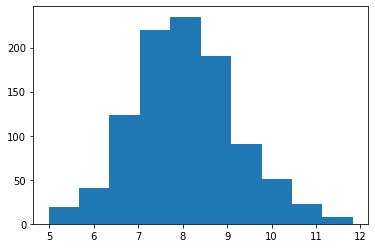

In [27]:
import warnings

def monte_carlo(n_trials=100,nsims=100,nobs=100):
    n_trials = 1000
    llrs = []
    for i in range(n_trials):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            yn,xn,nobs = gen_data(nobs=nobs)
            llr = standardize(setup_test(xn,yn,nsims=nsims))
            llrs.append(llr)
    return np.array(llrs)


llrs= monte_carlo()
plt.hist(llrs)
print(llrs.var())
print(llrs.mean())

1.3309742697106854
8.023844051374565
1.316028323067263
9.671593513657848
1.1354711362013503
11.301350872770014


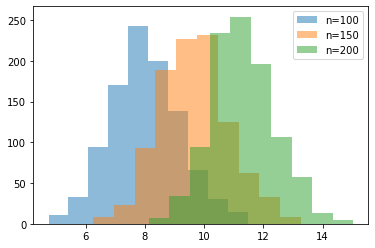

In [28]:
for i in [1,1.5,2]:
    llrs = monte_carlo(nobs= int(100*i), nsims = int(100*i))
    plt.hist(llrs,alpha=.5,label='n=' + str( int(i*100) ) )
    print(llrs.var())
    print(llrs.mean())
    
plt.legend()
plt.savefig('consist_quad.png',dpi=300)
plt.show()